# LOAD DATA

In [1]:
import pandas as pd
import ast

df = pd.read_csv('./data/df_all_preprocessed_noun.csv', 
                 sep=',', 
                 quoting=1)
df['nouns'] = df['nouns'].apply(
    lambda x: ast.literal_eval(x))
df.shape

(15662, 7)

# INPUT FEATURE SELECTION

In [2]:
stopwords = ['윤석열', '대통령', '이재명', '대표', 
             '더불어민주당', '민주당', '국민', '국민의힘',
            '때문', '기자', '무단', '배포', '금지']

from itertools import chain
from collections import Counter

nouns_list_flat = list(chain(*df['nouns']))
count_dict = Counter(nouns_list_flat)
count_dict_sorted = sorted(
    count_dict.items(), 
    key=lambda x: x[1],
    reverse=True)

input_feature_list = [
   word for word, count in count_dict_sorted
    if count > 100 and 
       len(word) > 1 and 
       word not in stopwords
]
len(input_feature_list)

3388

# DOCUMENT-TERM MATRIX

In [3]:
news_count_list = [
    Counter(news_noun) for news_noun in df['nouns']]
news_count_list = [
    [int(count[f] > 0) for f in input_feature_list] 
     for count in news_count_list]

dtm = pd.DataFrame(
    news_count_list,
    columns=input_feature_list)
print(dtm.shape)

(15662, 3388)


In [4]:
dtm

,탄핵,의원,국회,내란,헌법,정치,서울,조사,심판,체포,...,국적,결사,슬로건,미래한국,동향,전진,구독자,낭독,재심,3·1절
0,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15657,1,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15658,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15659,0,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
15660,1,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
print(f"n_samples: {dtm.shape[0]}, n_features: {dtm.shape[1]}")

n_samples: 15662, n_features: 3388


In [34]:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

# K-MEANS CLUSTERING

In [11]:
from sklearn.cluster import KMeans

# K-means with 3 clusters on scaled data
X = dtm.values
km = KMeans(n_clusters=3, random_state=1)
km.fit(X)

KMeans(n_clusters=3, random_state=1)

In [12]:
# review the cluster labels
km.labels_

array([1, 1, 2, ..., 2, 1, 2])

In [ ]:
cluster_ids, cluster_sizes = np.unique(km.labels_, return_counts=True)
print(f"Number of elements assigned to each cluster: {cluster_sizes}")

# CHOOSING THE BEST K

In [13]:
# save the cluster labels and sort by cluster
from sklearn.metrics import silhouette_score

numClusters = range(2, 15) 
SSE = []
silhouette = []
# for the number of clusters from 2 to 14,
for k in numClusters:
    # clustering
    k_means = KMeans(n_clusters=k, random_state=1)
    k_means.fit(X)
    # check WSS
    wss = k_means.inertia_
    SSE.append(wss)
    # check silhouette
    sil = silhouette_score(X, k_means.labels_)
    silhouette.append(sil)

print(SSE)
print(silhouette)

[1408490.4853607255, 1390637.7161707473, 1374183.5903743797, 1363757.0073507354, 1361043.2458401646, 1360689.074321366, 1342080.900639496, 1328498.269598712, 1323883.708951892, 1321245.5294599058, 1315721.3645475241, 1312431.2644900926, 1310001.009146142]
[0.1633539829662349, 0.060840394557664976, 0.036866073686322436, 0.014359362954327116, 0.015852334217604614, 0.016134241534616237, -0.06554863652866813, -0.07223375329778664, -0.07548264675215705, -0.0903922057918277, -0.0863956898852273, -0.0792008735822846, -0.08152909105580869]


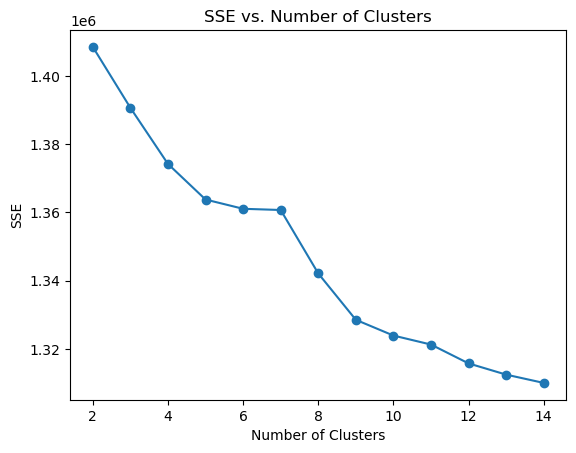

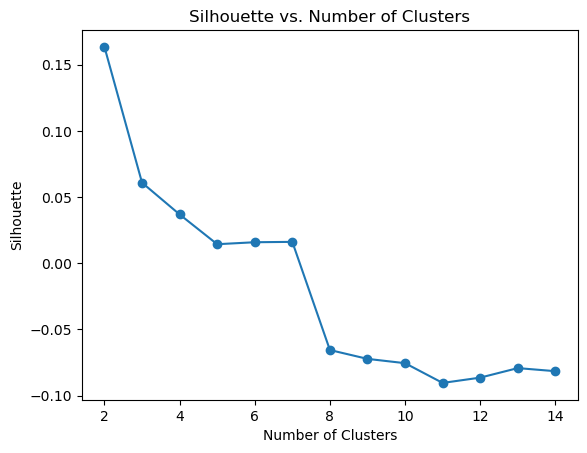

In [14]:
# visualization
import matplotlib.pyplot as plt

plt.plot(numClusters, SSE, marker='o')
plt.title('SSE vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

plt.plot(numClusters, silhouette, marker='o')
plt.title('Silhouette vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette')
plt.show()

In [15]:
k_means = KMeans(n_clusters=5, random_state=1)
k_means.fit(X)

# df['cluster'] = k_means.labels_
dtm['cluster'] = k_means.labels_
dtm.sort_values(by='cluster')

,탄핵,의원,국회,내란,헌법,정치,서울,조사,심판,체포,...,결사,슬로건,미래한국,동향,전진,구독자,낭독,재심,3·1절,cluster
7830,1,1,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10040,1,1,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
12682,1,1,0,1,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10010,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
12695,1,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8811,0,0,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,4
8808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
8803,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
8880,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [17]:
# review the cluster centers
centroids = dtm.groupby('cluster').mean()

In [25]:
for i in range(5):
    print(i, centroids.iloc[i].sort_values(ascending=False).index[:10].values)

0 ['탄핵' '정치' '국회' '상황' '문제' '이후' '가능' '사람' '의원' '헌법']
1 ['탄핵' '헌법' '심판' '재판소' '국회' '내란' '헌재' '서울' '주장' '이날']
2 ['대선' '정치' '국회' '의원' '탄핵' '지지' '강조' '관련' '상황' '조기']
3 ['혐의' '서울' '관련' '내란' '수사' '체포' '주장' '국회' '법원' '이날']
4 ['서울' '국회' '탄핵' '의원' '뉴스' '이날' '연합뉴스' '오후' '내란' '전재']
